## https://github.com/aws/amazon-sagemaker-examples/blob/main/introduction_to_amazon_algorithms/blazingtext_word2vec_text8/blazingtext_word2vec_text8.ipynb

In [1]:
arabic_text = '''المعلمة,مرحباً يا أطفال، ماذا تحبون أن تأكلوا للغداء؟'
الطالب 1,أنا أحب البيتزا!
المعلمة,جيد، وأنت يا سارة؟
سارة,أنا أحب الأرز والدجاج.
المعلمة,هل تحبون الفواكه؟
الطالب 2,نعم، أحب التفاح.
المعلمة,وأنا أحب الموز. الفواكه صحية لنا.'''

In [2]:
arabic_text

"المعلمة,مرحباً يا أطفال، ماذا تحبون أن تأكلوا للغداء؟'\nالطالب 1,أنا أحب البيتزا!\nالمعلمة,جيد، وأنت يا سارة؟\nسارة,أنا أحب الأرز والدجاج.\nالمعلمة,هل تحبون الفواكه؟\nالطالب 2,نعم، أحب التفاح.\nالمعلمة,وأنا أحب الموز. الفواكه صحية لنا."

In [1]:
import sagemaker
from sagemaker import get_execution_role
import boto3
import json

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [2]:
aws_role = get_execution_role()


sm_role = sagemaker.get_execution_role()

aws_region = boto3.Session().region_name
sm_session = sagemaker.Session()

print(f"Using Role: {sm_role}")
s3_bucket = sm_session.default_bucket()
s3_bucket

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Using Role: arn:aws:iam::287758680514:role/service-role/AmazonSageMaker-ExecutionRole-20231027T004238


'sagemaker-us-east-1-287758680514'

In [3]:
s3_bucket

'sagemaker-us-east-1-287758680514'

In [4]:
container = sagemaker.amazon.amazon_estimator.get_image_uri(aws_region, "blazingtext", "latest")

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


In [9]:
print(f"Using SageMaker BlazingText container: {container} ({aws_region})")

Using SageMaker BlazingText container: 811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:1 (us-east-1)


In [9]:
!ls -al

total 97696
drwxrwxr-x 3 ec2-user ec2-user      4096 Nov 27 02:12 .
drwxrwxr-x 6 ec2-user ec2-user      4096 Nov 25 21:37 ..
drwxrwxr-x 2 ec2-user ec2-user      4096 Nov 25 21:37 .ipynb_checkpoints
-rw-rw-r-- 1 ec2-user ec2-user 100000000 Nov 25 21:36 text8
-rw-rw-r-- 1 ec2-user ec2-user     21524 Nov 27 02:12 trainArabicVectors.ipynb


In [8]:
s3_client = boto3.client("s3")

data_bucket = (
    f"sagemaker-example-files-prod-{aws_region}"  # Replace with the bucket where your data is located
)
data_prefix = "datasets/text/text8/text8"

output_bucket = s3_bucket
output_prefix = "blazingText"
# s3_client.download_file(data_bucket, data_prefix, "text8")
s3_client.upload_file("./text8", output_bucket, output_prefix + "/train")

s3_train_data = f"s3://{output_bucket}/{output_prefix}/train"

In [10]:
s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"

In [12]:
bt_model = sagemaker.estimator.Estimator(
    container,
    aws_role,
    instance_count=2,
    instance_type="ml.c4.2xlarge",
    train_volume_size=5,
    train_max_run=360000,
    input_mode="File",
    output_path=s3_output_location,
    sagemaker_session=sm_session,
)

train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_volume_size has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [13]:
bt_model

In [14]:
bt_model.set_hyperparameters(
    mode="batch_skipgram",
    epochs=5,
    min_count=5,
    sampling_threshold=0.0001,
    learning_rate=0.05,
    window_size=5,
    vector_dim=100,
    negative_samples=5,
    batch_size=11,  #  = (2*window_size + 1) (Preferred. Used only if mode is batch_skipgram)
    evaluation=True,  # Perform similarity evaluation on WS-353 dataset at the end of training
    subwords=False,
)  # Subword embedding learning is not supported by batch_skipgram

In [15]:
train_data = sagemaker.session.s3_input(
    s3_train_data,
    distribution="FullyReplicated",
    content_type="text/plain",
    s3_data_type="S3Prefix",
)
data_channels = {"train": train_data}

The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [16]:
train_data

<sagemaker.deprecations.deprecated_class.<locals>.DeprecatedClass at 0x7fbe78fe0c70>

In [17]:
bt_model.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: blazingtext-2023-11-27-03-38-47-750


2023-11-27 03:38:47 Starting - Starting the training job...
2023-11-27 03:39:12 Starting - Preparing the instances for training.........
2023-11-27 03:40:43 Downloading - Downloading input data...
2023-11-27 03:41:14 Training - Training image download completed. Training in progress..Arguments: train
Found 10.0.136.236 for host algo-1
Found 10.0.145.8 for host algo-2
Arguments: train
Found 10.0.136.236 for host algo-1
Found 10.0.145.8 for host algo-2
/opt/amazon/lib/python3.8/site-packages/blazingtext/train_methods.py:176: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if p.poll() is not 0:
/opt/amazon/lib/python3.8/site-packages/blazingtext/train_methods.py:253: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if p.poll() is not 0:
/opt/amazon/lib/python3.8/site-packages/blazingtext/train_methods.py:326: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if p.poll() is not 0:
[11/27/2023 03:41:28 WARNING 140176788404032] Loggers have already been se

In [18]:
bt_endpoint = bt_model.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")


INFO:sagemaker:Creating model with name: blazingtext-2023-11-27-04-02-32-286
INFO:sagemaker:Creating endpoint-config with name blazingtext-2023-11-27-04-02-32-286
INFO:sagemaker:Creating endpoint with name blazingtext-2023-11-27-04-02-32-286


------!

In [19]:
words = ["awesome", "blazing"]

payload = {"instances": words}

response = bt_endpoint.predict(
    json.dumps(payload),
    initial_args={"ContentType": "application/json", "Accept": "application/json"},
)

vecs = json.loads(response)
print(vecs)

[{'vector': [0.13393311202526093, 0.0612756572663784, -0.09868907183408737, -0.1819951832294464, -0.035429924726486206, 0.08246875554323196, -0.034114379435777664, -0.05876420810818672, -0.08402327448129654, 0.2942201495170593, -0.22032085061073303, -0.00895718950778246, 0.12440434843301773, -0.031127093359827995, 0.17387306690216064, 0.05989725515246391, -0.0512256883084774, 0.08183690160512924, 0.14326703548431396, 0.03712720796465874, -0.007649960462003946, 0.0378432422876358, -0.1145324781537056, -0.0394502691924572, 0.03345382586121559, 0.03068653866648674, 0.057554762810468674, 0.16895553469657898, 0.02985587902367115, 0.2114941030740738, -0.0640394538640976, 0.06986134499311447, 0.0355696976184845, -0.11527035385370255, -0.22356215119361877, -0.044480327516794205, 0.05285533145070076, -0.016091255471110344, -0.15814632177352905, 0.0965515673160553, 0.04104989022016525, -0.006657361518591642, -0.1509200483560562, -0.03693549707531929, 0.3606105148792267, -0.16277675330638885, 0.1

In [21]:
len(vecs)

2

In [27]:
len(vecs[0])

2

In [33]:
len(vecs[0]['vector'])

100

In [36]:
vecs[1]['word']

'blazing'

In [37]:
s3 = boto3.resource("s3")

key = bt_model.model_data[bt_model.model_data.find("/", 5) + 1 :]
s3.Bucket(output_bucket).download_file(key, "model.tar.gz")

In [42]:
!tar -xvzf model.tar.gz

tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
eval.json
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
vectors.bin
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
vectors.txt


In [39]:
bt_model.model_data

's3://sagemaker-us-east-1-287758680514/blazingText/output/blazingtext-2023-11-27-03-38-47-750/output/model.tar.gz'

In [43]:
import numpy as np
from sklearn.preprocessing import normalize

# Read the 400 most frequent word vectors. The vectors in the file are in descending order of frequency.
num_points = 400

first_line = True
index_to_word = []
with open("vectors.txt", "r") as f:
    for line_num, line in enumerate(f):
        if first_line:
            dim = int(line.strip().split()[1])
            word_vecs = np.zeros((num_points, dim), dtype=float)
            first_line = False
            continue
        line = line.strip()
        word = line.split()[0]
        vec = word_vecs[line_num - 1]
        for index, vec_val in enumerate(line.split()[1:]):
            vec[index] = float(vec_val)
        index_to_word.append(word)
        if line_num >= num_points:
            break
word_vecs = normalize(word_vecs, copy=False, return_norm=False)

In [44]:
word_vecs

array([[ 0.13395498, -0.03474327,  0.01286177, ...,  0.11068553,
         0.05034122, -0.16800494],
       [ 0.12140019, -0.02601119,  0.07303833, ...,  0.01975542,
         0.08935875, -0.2292752 ],
       [ 0.10019859,  0.06517155,  0.05367771, ...,  0.0642343 ,
        -0.01892087, -0.13406431],
       ...,
       [-0.10431184,  0.03195243,  0.10179784, ...,  0.03927834,
        -0.1592134 ,  0.02715229],
       [ 0.05749755,  0.13947075, -0.0049126 , ...,  0.16503595,
        -0.05134186,  0.02060616],
       [ 0.10666162, -0.04402465,  0.19409201, ..., -0.01040054,
        -0.06587494, -0.05100438]])

In [45]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=40, n_components=2, init="pca", n_iter=10000)
two_d_embeddings = tsne.fit_transform(word_vecs[:num_points])
labels = index_to_word[:num_points]

INFO:matplotlib.font_manager:generated new fontManager


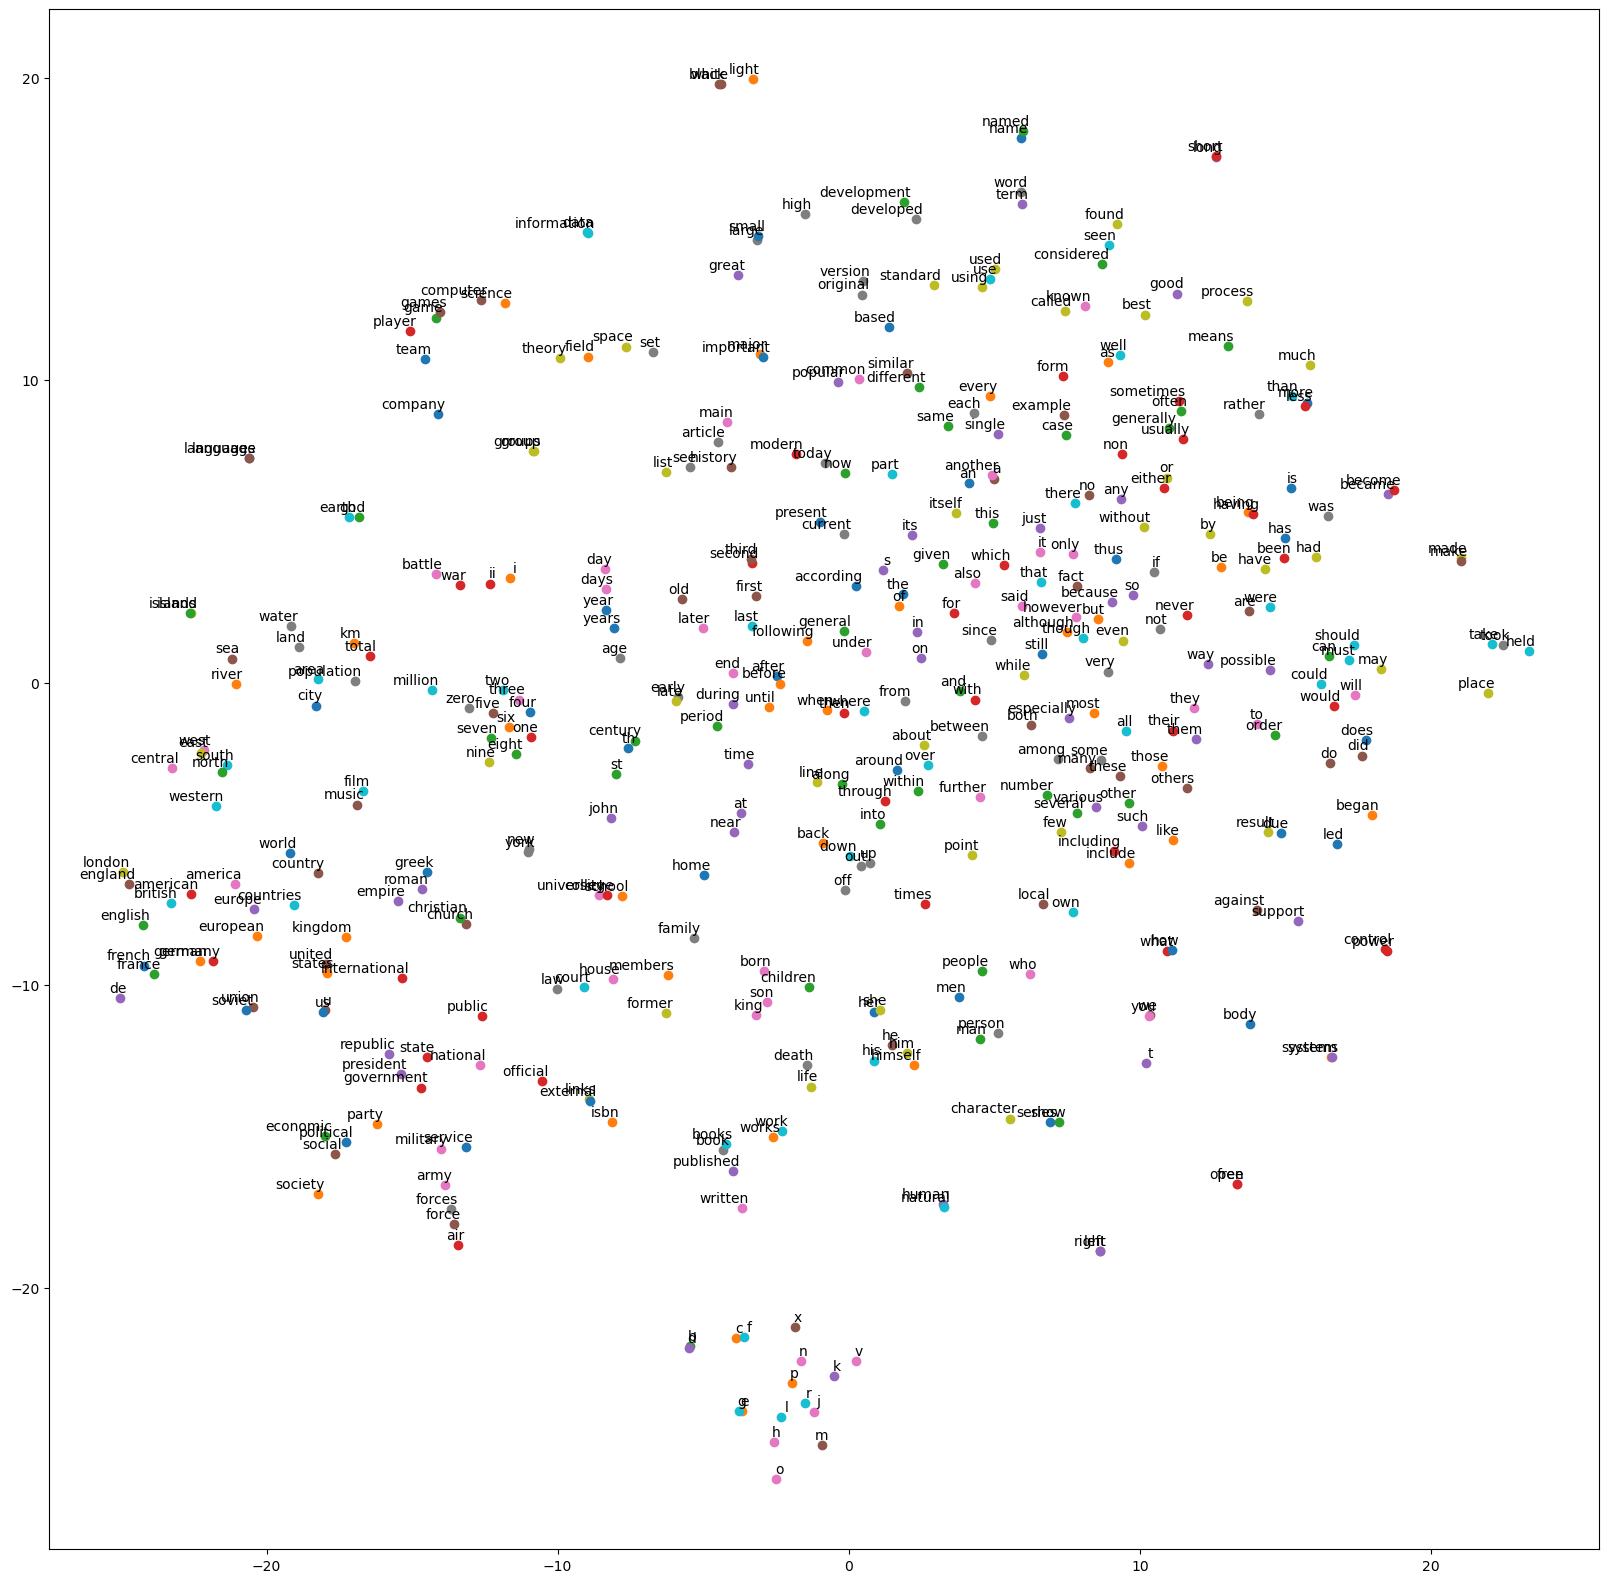

In [46]:
from matplotlib import pylab

%matplotlib inline


def plot(embeddings, labels):
    pylab.figure(figsize=(20, 20))
    for i, label in enumerate(labels):
        x, y = embeddings[i, :]
        pylab.scatter(x, y)
        pylab.annotate(
            label, xy=(x, y), xytext=(5, 2), textcoords="offset points", ha="right", va="bottom"
        )
    pylab.show()


plot(two_d_embeddings, labels)

In [49]:
sm_session.delete_endpoint(bt_endpoint.endpoint)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Deleting endpoint with name: blazingtext-2023-11-27-04-02-32-286
